# Mapping simulated lineage-traced single-cells across time points

This tutorial shows how to use the {class}`~moscot.problems.time.LineageProblem` to analyze simulated data containing both gene expression and lineage information (barcodes).

:::{seealso}
- TODO: link to other tutorials
:::

## Imports and data loading

In [1]:
import warnings

import moscot as mt
import moscot.plotting as mpl
from moscot import datasets
from moscot.problems.time import LineageProblem

import networkx as nx
import numpy as np

import scanpy as sc

warnings.simplefilter("ignore", UserWarning)

### Dataset description

TODO(MUCKD): needs to be updated

The simulation of this dataset models cell divisions, mimicking the evolution from a root cell. For this dataset, cell types are annotated according to the latent state, with state `7` corresponding to the root (least mature) state, while states `5` and `6` are intermediate states, evolving into terminal cell states `1`, `2`, `3`, or `4`.

Notably, the {func}`~moscot.datasets.tedsim` simulated dataset {cite}`pan:22` contains:

- {attr}`obs['time'] <anndata.AnnData.obs>` is assigned only to cells at depth `8` and `12`, presenting an early and late time point, respectively.
- {attr}`obsp['cost_matrices'] <anndata.AnnData.obsp>` contains a the pre-computed barcodes distance cost matrix only for the `8` and `12` depth cells.

:::{warning}
This dataset is approximately **2.07GiB** in size due to the saved cost matrices.
:::

In [2]:
adata = datasets.tedsim()
adata

AnnData object with n_obs × n_vars = 16382 × 500
    obs: 'parent', 'cluster', 'depth', 'cellID', 'time'
    uns: 'cluster_colors', 'metadata', 'tree'
    obsm: 'barcodes'
    obsp: 'cost_matrices'

For the sake of completeness, the {class}`~anndata.AnnData` object contains the full output of the simulation. For this tutorial, we restrict ourselves to time points `8` and `12`.

In [3]:
adata = adata[adata.obs["time"].isin([8.0, 12.0])].copy()
adata

AnnData object with n_obs × n_vars = 8448 × 500
    obs: 'parent', 'cluster', 'depth', 'cellID', 'time'
    uns: 'cluster_colors', 'metadata', 'tree'
    obsm: 'barcodes'
    obsp: 'cost_matrices'

### Preprocessing

We first need to preprocess the data compute the *UMAP*.

In [4]:
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

And explicitly convert some annotations to categorical, hence we create new columns.
TODO(MUCDK): this seems unnecessary

In [5]:
adata.obs["celltype"] = adata.obs["cluster"].astype("str").astype("category")
adata.obs["time_categorical"] = adata.obs["time"].astype("category")

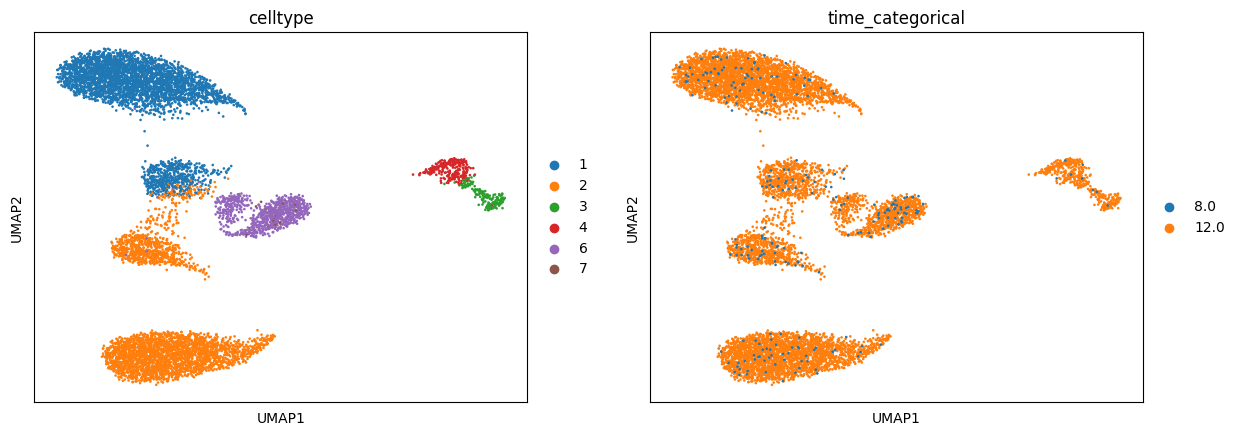

In [6]:
sc.pl.umap(adata, color=["celltype", "time_categorical"])

## Prepare the {class}`~moscot.problems.time.LineageProblem`

Apart from the `time_key` we need to set the `joint_attr` which defines where to look for the gene expression data. As we do not have a precomputed embedding, we set it to {obj}`None`, as this way *PCA* will performed on the {attr}`~anndata.AnnData.X` attribute.
If we did not have precomputed cost matrices we could also set the `lineage_attr` to `{'attr': 'obsm', 'key': 'barcodes', 'cost': 'barcode_distance'}`, which computes the cost matrices based on barcodes.
Since the {class}`~anndata.AnnData` object already contains the precomputed cost matrices, we simply extract them, as shown below.

In [7]:
lp = LineageProblem(adata=adata)
lp = lp.prepare(
    time_key="time",
    joint_attr=None,
    lineage_attr={"attr": "obsp", "key": "cost_matrices"},
)

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  


## Solve the {class}`~moscot.problems.time.LineageProblem`

The `alpha` parameter determines the influence of the lineage term as opposed to the gene expression. It must be in  $(0, 1]$. We choose `epsilon` to be small to get a crisper transport map. 

In [8]:
lp = lp.solve(alpha=0.99, epsilon=1e-3)

INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(256, 8192)].                                   


## Analyzing cell type transitions

Now, we can compute the descendants of cells at time point `8`, aggregated by cell type.

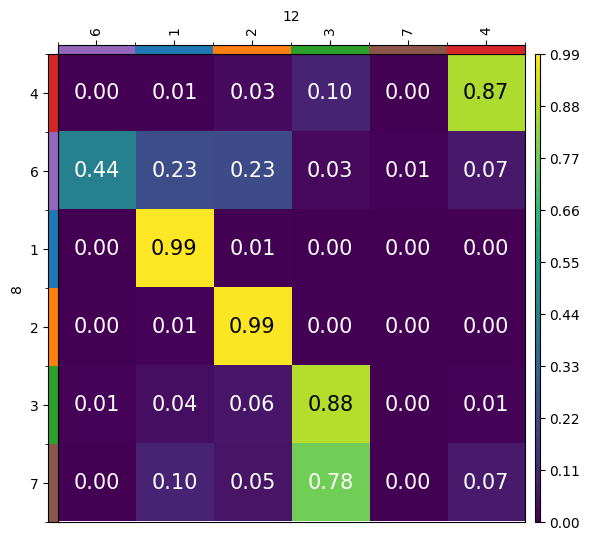

In [9]:
cell_transition = lp.cell_transition(
    source=8,
    target=12,
    source_groups="celltype",
    target_groups="celltype",
    forward=True,
)

mpl.cell_transition(lp, fontsize=15, figsize=(5, 5))

Similarly, we can plot ancestors by setting `forward=False`.

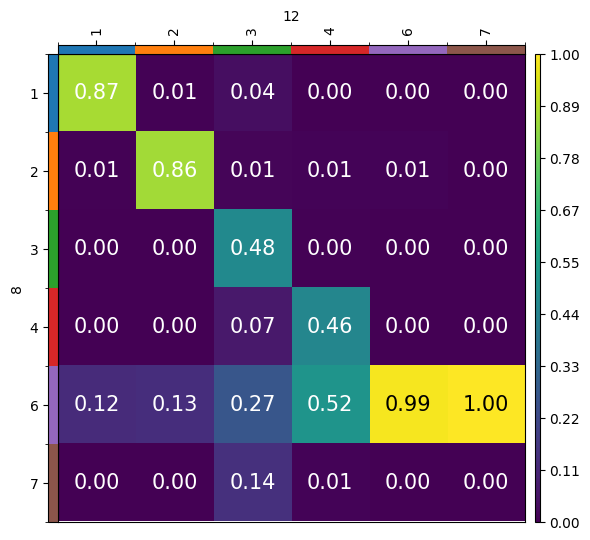

In [10]:
cell_transition = lp.cell_transition(
    source=8,
    target=12,
    source_groups="celltype",
    target_groups="celltype",
    forward=False,
)

mpl.cell_transition(lp, fontsize=15, figsize=(5, 5))

Another way to visualize cell type transitions is using a Sankey diagram. We order the annotations explicitly by providing a dictionary for `source_groups` and `target_groups`.

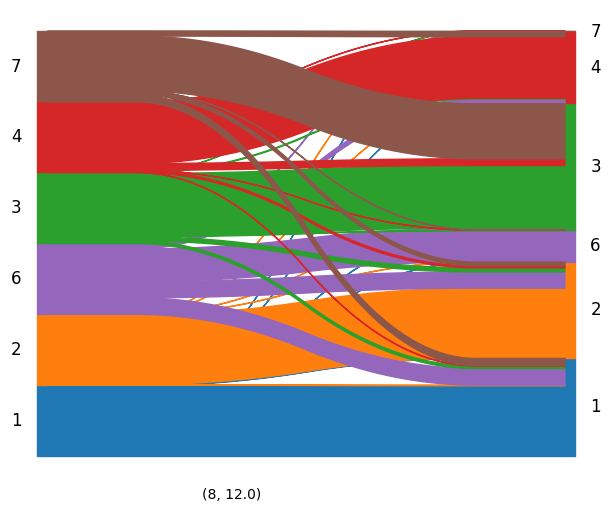

In [11]:
order = ["1", "2", "6", "3", "4", "7"]
lp.sankey(
    source=8,
    target=12,
    source_groups={"celltype": order},
    target_groups={"celltype": order},
)
mpl.sankey(lp, figsize=(6, 5))

## Finding subclusters

Here, we subcluster the relatively large cell type `6`.

In [12]:
sc.tl.leiden(
    adata, restrict_to=("celltype", ["6"]), resolution=0.4, key_added="celltype_refined"
)

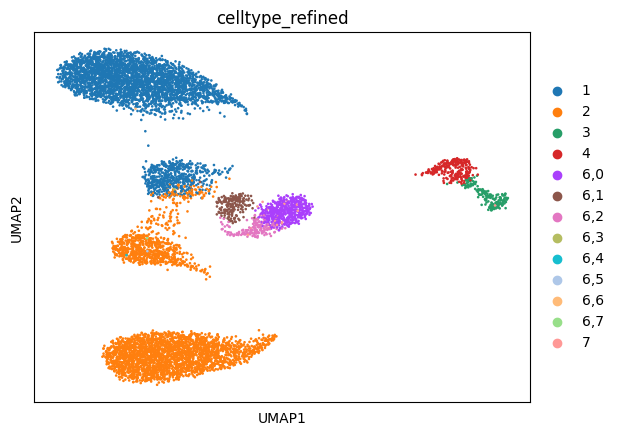

In [13]:
sc.pl.umap(adata, color="celltype_refined")

We are specifically interested where the subclusters of cell type `6` map to, hence we restrict the rows of the transition matrix to the corresponding subclusters. 

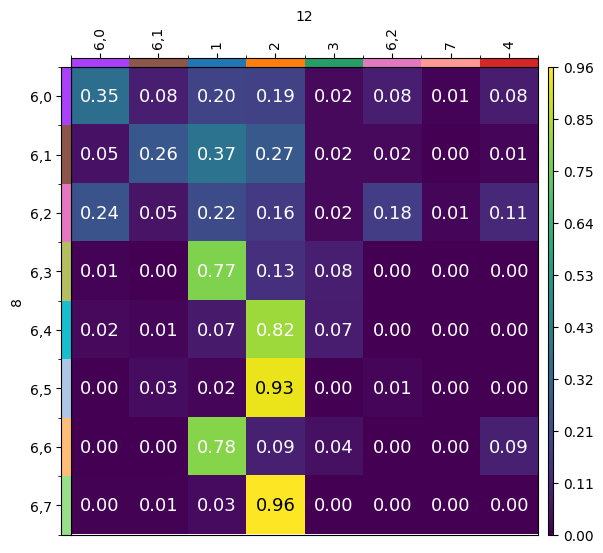

In [14]:
cell_transition = lp.cell_transition(
    source=8,
    target=12,
    source_groups={
        "celltype_refined": ["6,0", "6,1", "6,2", "6,3", "6,4", "6,5", "6,6", "6,7"]
    },
    target_groups="celltype_refined",
    forward=True,
)

mpl.cell_transition(lp, fontsize=13, figsize=(5, 5))

We can see that subclusters `6,3` and `6,6` mainly precede cluster `1`, while `6,4`, `6,5`, and `6,7` precede cluster `2`. Note that only subcluster `6,0`, `6,1`, and `6,2 `have cells belonging to the later time point.